# Variational Quantum Eigensolver (VQE) using PennyLane
## Overview
Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to estimate the ground-state energy of molecular systems. In this tutorial, we demonstrate how to use PennyLane to perform VQE on the Beryllium Hydride (BeH₂) molecule. We start by building the molecular Hamiltonian then prepares a trial wave function, and the classical optimizer adjusts the parameters to minimize the energy.

## 1. Building the electronic Hamiltonoian

### Import necessary libraries


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import functools

### Define molecular geometry

In [12]:
mol=qml.qchem.mol_data("BeH2")
symbols = ["H","Be","H"]
geometry = np.array([[0.0, 0.0, -1.7],[0.0,0.0,0.0], [0.0, 0.0, 1.7]]) 

In [9]:
mol1=qml.qchem.mol_data("BeH2")
print(mol1)

(['Be', 'H', 'H'], tensor([[ 4.79404621,  0.29290755,  0.        ],
        [ 3.77945225, -0.29290755,  0.        ],
        [ 5.80882913, -0.29290755,  0.        ]], requires_grad=True))


### Define active space

Define an active space to perform quantum simulations with a reduced number of qubits by classifying the molecular orbitals as core and active orbitals.

In [3]:
core, active = qml.qchem.active_space(6, 5, active_electrons=4, active_orbitals=3)
print('core orbitals:', core, '\nactive orbitals:', active )

core orbitals: [0] 
active orbitals: [1, 2, 3]


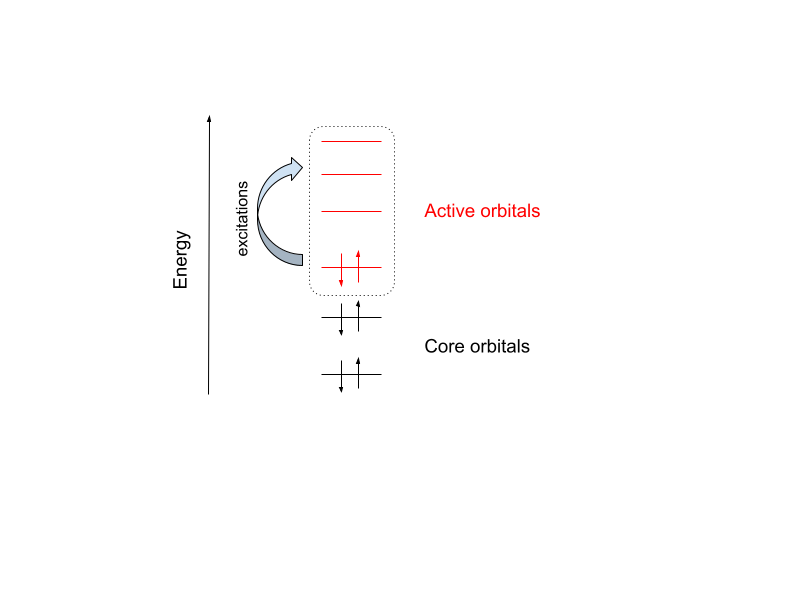

### Build the Hamiltonian

In [11]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, active_electrons=4, active_orbitals=4)
print('qubits:',qubits,'\n\nH =',H)

qubits: 8 

H =   (-14.225298300082315) [I0]
+ (-0.017858339631270377) [Z4]
+ (-0.017858339631270377) [Z5]
+ (-0.01785833963125627) [Z7]
+ (-0.01785833963125623) [Z6]
+ (0.18376934404852158) [Z3]
+ (0.1837693440485218) [Z2]
+ (0.189293865627094) [Z0]
+ (0.189293865627094) [Z1]
+ (0.07464706092699114) [Z0 Z2]
+ (0.07464706092699114) [Z1 Z3]
+ (0.0872371502053069) [Z0 Z4]
+ (0.0872371502053069) [Z1 Z5]
+ (0.0872371502053263) [Z0 Z6]
+ (0.0872371502053263) [Z1 Z7]
+ (0.09401471929144516) [Z2 Z4]
+ (0.09401471929144516) [Z3 Z5]
+ (0.09401471929146607) [Z2 Z6]
+ (0.09401471929146607) [Z3 Z7]
+ (0.0942777355550643) [Z4 Z6]
+ (0.0942777355550643) [Z5 Z7]
+ (0.0987691272565404) [Z2 Z5]
+ (0.0987691272565404) [Z3 Z4]
+ (0.09876912725656237) [Z2 Z7]
+ (0.09876912725656237) [Z3 Z6]
+ (0.10034008122331718) [Z4 Z7]
+ (0.10034008122331718) [Z5 Z6]
+ (0.10166582964774823) [Z0 Z5]
+ (0.10166582964774823) [Z1 Z4]
+ (0.10166582964777082) [Z0 Z7]
+ (0.10166582964777082) [Z1 Z6]
+ (0.11246477255979793) [Z

charge=0, mult=1, basis='sto-3g', method='dhf', active_electrons=4, active_orbitals=4, mapping='jordan_wigner'

## 2. Simulation Setup

Define the cost function to compute the expectation value of the molecular Hamiltonian in the trial state prepared by the circuit.

### Prepare initial state and ansatz

In [12]:
initial_state = qml.qchem.hf_state(4,qubits)
singles, doubles = qml.qchem.excitations(4, qubits)
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
ansatz = functools.partial(qml.UCCSD, init_state=initial_state, s_wires=s_wires, d_wires=d_wires)

### Visualize the circuit

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

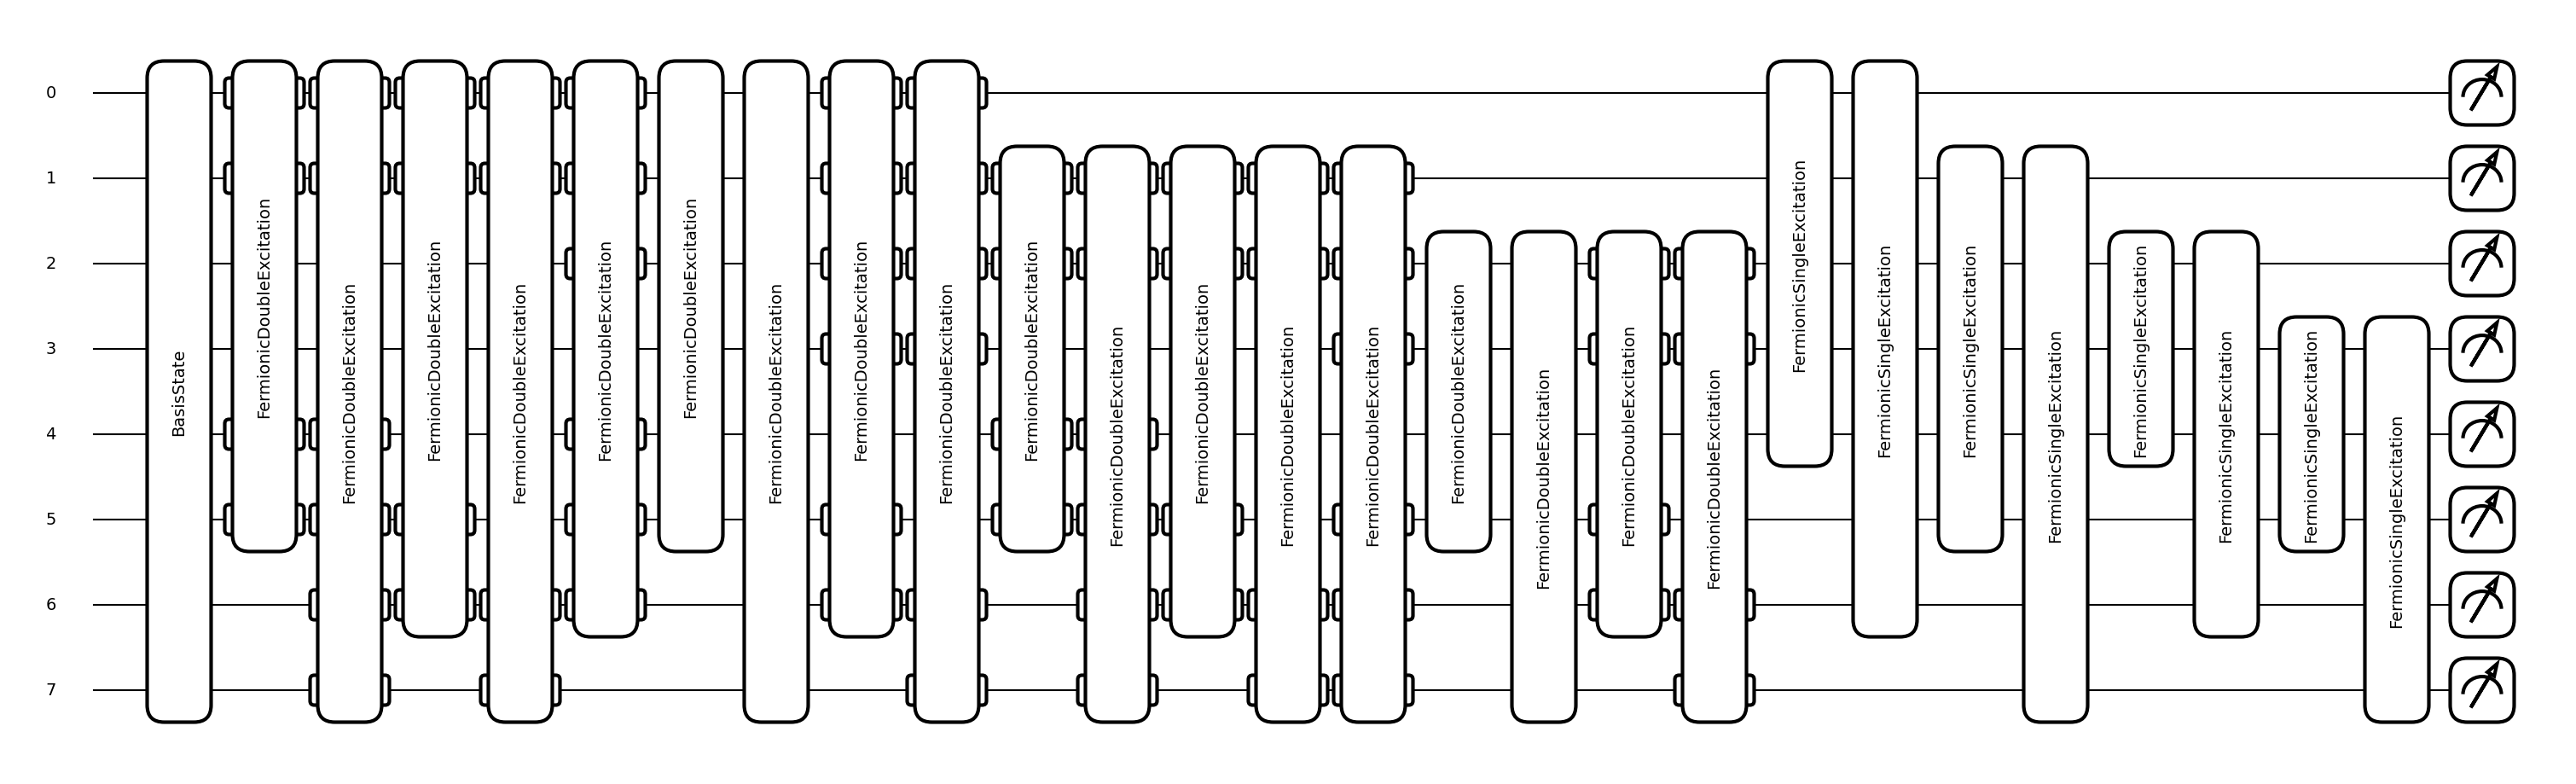

In [13]:
qml.draw_mpl(cost)(np.zeros(len(singles)+len(doubles)))

### Define the device and cost function

In [ ]:
dev = qml.device('lightning.qubit', wires=qubits)
@qml.qnode(dev)
def cost(params):
    ansatz(params, wires=dev.wires)
    return qml.expval(H)  

## 3. Running the VQE Optimization
Now we proceed to minimize the cost function to find the ground state of the  $BeH_{2}$
  molecule. To start, we need to define the classical optimizer and initialize the circuit parameter $\theta$.

### Initialize optimizer and parameters

In [14]:
optimizer = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.array(np.random.normal(0, np.pi, len(singles) + len(doubles)), requires_grad=True)
print(cost(theta))

-14.54714957820648


### Optimization loop

In [15]:
# store the values of the cost function
energy = [cost(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 80
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = optimizer.step_and_cost(cost, theta)

    energy.append(cost(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
#print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -14.63557759 Ha
Step = 2,  Energy = -14.78225259 Ha
Step = 4,  Energy = -14.88670434 Ha
Step = 6,  Energy = -14.95791760 Ha
Step = 8,  Energy = -15.00763932 Ha
Step = 10,  Energy = -15.04499395 Ha
Step = 12,  Energy = -15.07580596 Ha
Step = 14,  Energy = -15.10340072 Ha
Step = 16,  Energy = -15.12944838 Ha
Step = 18,  Energy = -15.15456471 Ha
Step = 20,  Energy = -15.17872483 Ha
Step = 22,  Energy = -15.20157124 Ha
Step = 24,  Energy = -15.22265201 Ha
Step = 26,  Energy = -15.24158903 Ha
Step = 28,  Energy = -15.25816881 Ha
Step = 30,  Energy = -15.27236184 Ha
Step = 32,  Energy = -15.28429206 Ha
Step = 34,  Energy = -15.29418402 Ha
Step = 36,  Energy = -15.30230986 Ha
Step = 38,  Energy = -15.30894833 Ha
Step = 40,  Energy = -15.31435887 Ha
Step = 42,  Energy = -15.31876880 Ha
Step = 44,  Energy = -15.32236951 Ha
Step = 46,  Energy = -15.32531797 Ha
Step = 48,  Energy = -15.32774085 Ha
Step = 50,  Energy = -15.32973939 Ha
Step = 52,  Energy = -15.33139419 Ha
Step =

## 4. Visualization of the Optimization Process

### Plot energy convergence

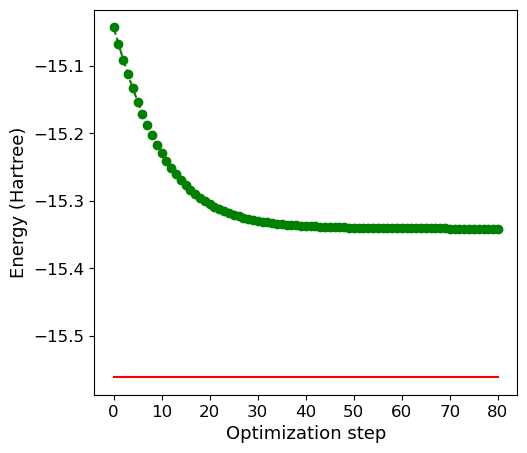

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -15.56089

ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## References
[1]
Alberto Peruzzo, Jarrod McClean et al., “A variational eigenvalue solver on a photonic quantum processor”. Nature Communications 5, 4213 (2014).

[2]
Jacob T. Seeley, Martin J. Richard, Peter J. Love. “The Bravyi-Kitaev transformation for quantum computation of electronic structure”. Journal of Chemical Physics 137, 224109 (2012).

[3] Yudong Cao, Jonathan Romero, et al., “Quantum Chemistry in the Age of Quantum Computing”. Chem. Rev. 2019, 119, 19, 10856-10915.

[4]
M. Born, J.R. Oppenheimer, “Quantum Theory of the Molecules”. Annalen der Physik 84, 457-484 (1927)

[5]
Rolf Seeger, John Pople. “Self‐consistent molecular orbital methods. XVIII. Constraints and stability in Hartree–Fock theory”. Journal of Chemical Physics 66, 3045 (1977).

[6]
J.T. Fermann, E.F. Valeev, “Fundamentals of Molecular Integrals Evaluation”. arXiv:2007.12057


[7]
J.J. Bao, S.S. Dong, L. Gagliardi, D.G. Truhlar. “Automatic Selection of an Active Space for Calculating Electronic Excitation Spectra by MS-CASPT2 or MC-PDFT”. Journal of Chemical Theory and Computation 14, 2017 (2018).

[8] PennyLane Tutorials: https://pennylane.ai/qml/demos/tutorial_vqe